In [1]:
# GD with momentum: https://github.com/VinitSR7/Logistic-Regression-with-Advanced-Optimizers/blob/master/SGD%20with%20Momentum.ipynb
# Implement NAG, ADAM, RMSProp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
import pandas as pd

def c_and_cprime(t, pars):
    c = pars['c0'] * np.exp(-pars['gamma'] * t)
    cp = -pars['gamma'] * pars['c0'] * np.exp(-pars['gamma'] * t)
    return c, cp

def solve_p(p0, F, h, pars):
    p = p0.copy()
    eps_reg = 1e-5
    # First RK4 step (g1)
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g1 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Second RK4 step (g2)
    p = p0 + 0.5 * h * g1
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g2 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Third RK4 step (g3)
    p = p0 + 0.5 * h * g2
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g3 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Fourth RK4 step (g4)
    p = p0 + h * g3
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g4 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Final RK4 update for p1
    p1 = p0 + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
    return p1

def kd_step(x, p, h, pars, Force):
    x, p, Force = x.reshape(-1), p.reshape(-1), Force.reshape(-1)
    x = x + 0.5 * h * p
    p = solve_p(p, Force, h, pars)
    x = x + 0.5 * h * p
    return x.reshape(-1,1), p.reshape(-1,1)

def hd_step(x, p, h, pars, Force):
    gamma = pars['gamma']
    delta = 1/(1 + gamma * h)
    p = delta * p + h * delta * Force
    x = x + h * p
    return x, p

def gd_step(x, p, h, pars, Force):
    x = x + h * Force
    return x, p

data = datasets.load_breast_cancer()
X = data['data']
Y = data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, shuffle = True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def sigmoid(X):
    return 1/(1+math.exp(-X)) 

def log_loss(y, y_):
    return -1*(y*math.log(sigmoid(y_)) + (1-y)*math.log(1-sigmoid(y_)))

def cal_grad(y,y_,x):
    return (y - sigmoid(y_)) * (x.reshape(-1, 1)) 

def train(X, Y, epochs, eta, pars, optimizer, batch_size):
    N = X.shape[1]
    w =  np.random.uniform(-1, 1, size = N).reshape(N, 1)
    p = np.random.uniform(-1, 1, size = N).reshape(N, 1)
    if optimizer == 'kd':
        p = (p / np.linalg.norm(p)) * np.sqrt(2 * pars['c0'])
    losses = []
    ps = [p]
    for epoch in range(epochs):
        epoch_loss = 0
        perm = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            gt = 0
            batch_loss = 0
            X_batch = X[perm[i:i + batch_size]]
            Y_batch = Y[perm[i:i + batch_size]]

            for j in range(len(X_batch)):
                y = Y_batch[j]
                x = X_batch[j].reshape(N, 1)
                y_ = np.dot(w.T, x)
                gt += cal_grad(y, y_, x)
                batch_loss += log_loss(y, y_)
            
            gt /= batch_size
            batch_loss /= batch_size

            if optimizer == 'gd':
                w, p = gd_step(w, p, eta, pars, gt)
            elif optimizer == 'hd':
                w, p = hd_step(w, p, eta, pars, gt)
            elif optimizer == 'kd':
                w, p = kd_step(w, p, eta, pars, gt)
            epoch_loss += batch_loss
        ps.append(p)
        losses.append(epoch_loss)
    ps = np.array(ps)
    return w, ps, losses

epochs = 10000
pars = {
    'c0': 1.,
    'gamma': 1.
    }
eta = 1e-3
w_kd, ps, loss_kd = train(X_train, Y_train, epochs, eta, pars, optimizer = 'kd', batch_size = 426)
w_hd, ps, loss_hd = train(X_train, Y_train, epochs, eta, pars, optimizer = 'hd', batch_size = 426)
w_gd, ps, loss_gd = train(X_train, Y_train, epochs, eta, pars, optimizer = 'gd', batch_size = 426)

,Train Accuracy,Test Accuracy
KD,0.929577,0.930070
HD,0.936620,0.944056
GD,0.943662,0.972028


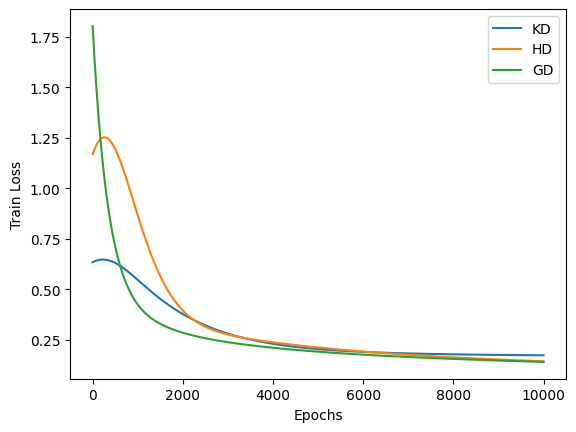

In [4]:
def predict(w, X):
    y_pred = []
    for i in range(len(X)):
        y_pred.append(np.round(sigmoid(np.dot(w.T, X[i].reshape(X.shape[1], 1)))))
    return y_pred

plt.plot(np.arange(epochs), loss_kd, label = 'KD')
plt.plot(np.arange(epochs), loss_hd, label = 'HD')
plt.plot(np.arange(epochs), loss_gd, label = 'GD')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

train_acc_kd = accuracy_score(Y_train, predict(w_kd, X_train))
train_acc_hd = accuracy_score(Y_train, predict(w_hd, X_train))
train_acc_gd = accuracy_score(Y_train, predict(w_gd, X_train))
test_acc_kd = accuracy_score(Y_test, predict(w_kd, X_test))
test_acc_hd = accuracy_score(Y_test, predict(w_hd, X_test))
test_acc_gd = accuracy_score(Y_test, predict(w_gd, X_test))

accuracy_data = {
    'Train Accuracy': [train_acc_kd, train_acc_hd, train_acc_gd],
    'Test Accuracy': [test_acc_kd, test_acc_hd, test_acc_gd]
}
index = ['KD', 'HD', 'GD']
accuracy_df = pd.DataFrame(accuracy_data, index=index)
accuracy_df